Handle the dependencies for training and plotting purposes

In [1]:
from keras.layers.convolutional import UpSampling2D
from keras.layers import (
    Dense,
    Activation,
    Conv2D,
    Conv2DTranspose,
    Input,
    Add,
    Reshape,
    BatchNormalization
)
from keras.models import (
    Sequential, Model
)
from keras.activations import (
    softmax,
    tanh,
    sigmoid,
    relu
)
import keras.backend as K
%matplotlib inline
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras.backend.tensorflow_backend import set_session
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [8]:
from utils.utils import GroupNormalization

Specifies the hyperparameters for trainning  
``Modifies the cell below for tunning the parameters``

In [2]:
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 1
DIS_LR = 0.0002
GEN_LR = 0.0002
DECAY = .99
X_PATH = './datasets/monet2photo/trainA'
Y_PATH = './datasets/monet2photo/trainB'

# Upsampling parameters
NUM_CONV_LAYERS = 2
INIT_FILTER = 16
KERNEL_SIZE = 3
CONV_STRIDES = (2, 2)

# Residual Block parameters
NUM_REPETITIONS = 2
NUM_RES_BLOCKS = 2
RES_STRIDES = (1, 1)

Defines helper functions

In [3]:
""" Return an activation function as needed"""
def activation_func(name):

    def leakyReLu(input_):
        return relu(input_, alpha=.2)
    
    get_custom_objects().update({'leakyReLu': Activation(leakyReLu)})
    
    return {
            'ReLU': relu,
            'tanh': tanh,
            'leakyReLU': leakyReLu,
            'sigmoid': sigmoid,
            'softmax': softmax
    }[name]

""" 
Plot the images inline using matplotlib.

This function takes in 8 pictures where 

X -> Original Picture X 
Y -> Original Picture Y
Y' -> generator_xy(X)
X' -> generator_yx(Y)
Y'' -> generator_xy(X')
X'' -> generator_yx(Y')
X_identical -> generator_yx(X)
Y_identical -> generator_xy(Y)

"""
def plot_images(*images):
    assert(len(images) == 8)
    image_names = ['X', 'Y', "Y'", "X'", "X''", "Y''", 'X_identical', 'Y_identical']
    
    # plt.rcParams['figure.figsize'] = [10, 10]
    
    for i, name in enumerate(image_names):
        image = ((images[i] + 1) / 2 * 255.).astype(int)
        plt.subplot(4, 2, i+1)
        plt.imshow(image)
        plt.title(name)
    
    plt.show()

In [5]:
class CycleGAN:
    def __init__(self):
        config = tf.ConfigProto(allow_soft_placement=True)
        config.gpu_options.allow_growth = True
        self.session = tf.Session(config=config)
        set_session(self.session)
        
        with tf.device('/device:GPU:0'):
            self.generator_xy = self.generator()
            self.generator_yx = self.generator()
        
        with tf.device('/device:GPU:1'):
            self.discriminator_x = self.discriminator()
            self.discriminator_y = self.discriminator()
        
            self.xy_Dataset = self.buildDataset()
        
            X, Y     = Input(INPUT_SHAPE)   , Input(INPUT_SHAPE)
            X_, Y_   = self.generator_yx(Y) , self.generator_xy(X)
            X__, Y__ = self.generator_yx(Y_), self.generator_xy(X_)
            X_identity, Y_identity = self.generator_yx(X), self.generator_xy(Y)

            adam_dis = optimizers.Adam(lr=DIS_LR)
            adam_gen = optimizers.Adam(lr=GEN_LR)
        
            self.discriminator_x.compile(loss='mse', optimizer=adam_dis, metrics=['accuracy'])
            self.discriminator_y.compile(loss='mse', optimizer=adam_dis, metrics=['accuracy'])

            self.discriminator_x.trainable = False
            self.discriminator_y.trainable = False

            X_valid, Y_valid = self.discriminator_x(X_), self.discriminator_y(Y_)
        
        with tf.device('/device:GPU:0'):
            # TODO: Figure out the weights of the losses
            self.generators = Model(
                    inputs=[X, Y], 
                    outputs=[X_valid, Y_valid, X_, Y_, X__, Y__, X_identity, Y_identity]
                )

            # The paper suggests using L1 norm for the last four loss functions, try out different settings if it doesn't work
            self.generators.compile(
                loss=['mse']*8,
                loss_weights=[1, 1, 0, 0, 10, 10, 1, 1],
                optimizer=adam_gen
            )

    def buildDataset(self, x_path = X_PATH, y_path = Y_PATH):        
        x_Dataset = tf.data.Dataset.list_files( x_path + '/*.jpg')
        y_Dataset = tf.data.Dataset.list_files( y_path + '/*.jpg')

        x_images = x_Dataset.map(lambda x: tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(x), channels = INPUT_SHAPE[2]), [INPUT_SHAPE[0], INPUT_SHAPE[1]]))
        y_images = y_Dataset.map(lambda x: tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(x), channels = INPUT_SHAPE[2]), [INPUT_SHAPE[0], INPUT_SHAPE[1]]))

        xy_images = tf.data.Dataset.zip((x_images, y_images))
        xy_Dataset = xy_images.batch(BATCH_SIZE)
        return xy_Dataset

    def discriminator(self):
        # Input is an image
        model = Sequential()
        filter_out = self.conv(model, 'leakyReLU')
        # Not sure if a binary discriminator needs residual blocks
        #self._addConvBlock(model, 'leakyReLU', filters=INIT_FILTERS, kernel_size=KERNEL_SIZE, strides=RES_STRIDES, input_layer=True)
        #self.residuals(model, 'leakyReLU', filter_out)
        self._addConvBlock(model, 'leakyReLU', filters=1, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES)
        model.add(Reshape((-1,)))
        model.add(Dense(1))

        return model

        
    def generator(self):
        model = Sequential()
        filter_out = self.conv(model, 'leakyReLU')
        self.residuals(model, 'leakyReLU', filter_out)
        self.deconv(model, 'leakyReLU', filter_out)
        model.add(Activation(activation_func('tanh')))

        return model
        
    # Downsampling - return the final filter size
    def conv(self, model, activations, init_filter=INIT_FILTER, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        self._addConvBlock(model, activations, init_filter, kernel_size, strides, True)

        for i in range(NUM_CONV_LAYERS-1):
            init_filter *= 2
            self._addConvBlock(model, activations, init_filter, kernel_size, strides)

        return init_filter
    
    def deconv(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        for i in range(NUM_CONV_LAYERS-1):
            filters //= 2
            self._addDeconvBlock(model, activations, filters, kernel_size, strides)

        self._addDeconvBlock(model, activations, INPUT_SHAPE[2], kernel_size, strides)

    def residuals(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=RES_STRIDES, repetitions=NUM_REPETITIONS):
        for i in range(NUM_RES_BLOCKS):
            self._addResBlock(model, activations, filters, kernel_size, strides, repetitions)

    def _addResBlock(self, model, activations, filters, kernel_size, strides, repetitions):
        for i in range(repetitions):
            self._addConvBlock(model, activations, filters, kernel_size, strides)
        

    def _addDeconvBlock(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        # model.add(GroupNormalization())
        model.add(BatchNormalization())
        model.add(Activation(activation_func(activations)))
        
        model.add(UpSampling2D(size=2))
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding='same', kernel_initializer='truncated_normal'))

    def _addConvBlock(self, model, activations, filters, kernel_size, strides, input_layer=False):
        if not input_layer:
            # model.add(GroupNormalization())
            model.add(BatchNormalization())
            model.add(Activation(activation_func(activations)))
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='truncated_normal'))
        else:
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', input_shape=INPUT_SHAPE, kernel_initializer='truncated_normal'))

    def train(self):
        # TODO: implements training process
        valid = np.ones((BATCH_SIZE, 1)) * .9
        fake  = np.zeros((BATCH_SIZE, 1))
        
        # self.discriminator_x.summary()
        # self.discriminator_y.summary()
        # self.generators.summary()
        
        for epoch in range(0,10):
            iterator = self.xy_Dataset.make_initializable_iterator()
            (x_next, y_next) = iterator.get_next()
            self.session.run(iterator.initializer)
            batch_i = 0
            
            while True:
                try:
                    # x_train, y_train = np.random.normal(size=[BATCH_SIZE, 256, 256, 3]), np.random.normal(size=[BATCH_SIZE, 256, 256, 3])
                    x_train, y_train = self.session.run([x_next, y_next])
                    
                    if x_train.shape[0] != BATCH_SIZE:
                        break
                    
                    x_train = (x_train / 255.0 - .5) * 2
                    y_train = (y_train / 255.0 - .5) * 2
                    
                    with tf.device('/device:GPU:1'):
                        x_valid, y_valid, x_, y_, x__, y__, x_identity, y_identity = self.generators.predict([x_train, y_train])
                        
                        d_x_real_loss = self.discriminator_x.train_on_batch(x_train, valid)
                        d_x_fake_loss = self.discriminator_x.train_on_batch(x_, fake)
                        d_x_loss = 0.5 * np.add(d_x_real_loss, d_x_fake_loss)

                        d_y_real_loss = self.discriminator_y.train_on_batch(y_train, valid)
                        d_y_fake_loss = self.discriminator_y.train_on_batch(y_, fake)
                        d_y_loss = 0.5 * np.add(d_y_real_loss, d_y_fake_loss)

                        # Total disciminator loss
                        d_loss = 0.5 * np.add(d_x_loss, d_y_loss)
                        
                    
                        # Total generator loss
                        g_loss = self.generators.train_on_batch([x_train, y_train],
                                                                [valid, valid,
                                                                 x_train, y_train,
                                                                 x_train, y_train,
                                                                 x_train, y_train])

                        if batch_i % 10 == 0:
                            plot_images(
                                x_train[0], y_train[0],
                                y_[0], x_[0],
                                x__[0], y__[0],
                                x_identity[0], y_identity[0]
                            )

                            print(
                                'Epoch: ', epoch,
                                'Batch: ', batch_i,
                                'Loss of Discriminator: ', d_loss, 
                                'Loss of Generator G: ', g_loss
                            )

                        batch_i += 1
                    
                
                except tf.errors.OutOfRangeError:
                    print('epoch ' + str( epoch) + ' end.')
                    break

    def test(self, x_test, y_test):
        # TODO: implements evaluation 
        pass

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


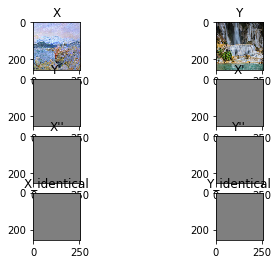

Epoch:  0 Batch:  0 Loss of Discriminator:  [0.59737414 0.5       ] Loss of Generator G:  [11.441232, 1.8847, 2.7215877, 0.29193437, 0.3004648, 0.3144005, 0.30487636, 0.33968505, 0.30249023]


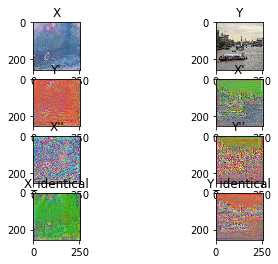

Epoch:  0 Batch:  10 Loss of Discriminator:  [0.7402678 0.       ] Loss of Generator G:  [6.102352, 0.8225187, 0.0322018, 0.15990052, 0.28831416, 0.15716219, 0.32190147, 0.14812216, 0.30887255]


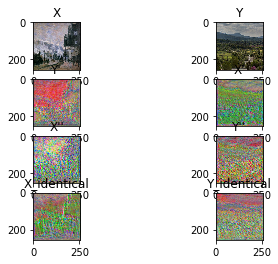

Epoch:  0 Batch:  20 Loss of Discriminator:  [0.16324039 0.5       ] Loss of Generator G:  [7.720794, 0.76984465, 0.0307957, 0.28759181, 0.40132904, 0.25407845, 0.37358376, 0.26967198, 0.37385988]


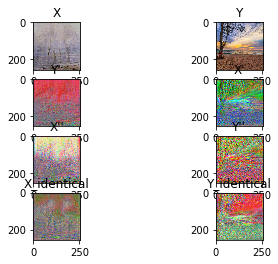

Epoch:  0 Batch:  30 Loss of Discriminator:  [0.04597443 0.5       ] Loss of Generator G:  [4.5591674, 0.21728723, 0.10345429, 0.1373494, 0.29441836, 0.121603556, 0.2614522, 0.12545748, 0.2824113]


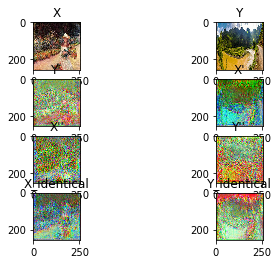

Epoch:  0 Batch:  40 Loss of Discriminator:  [0.39886016 0.25      ] Loss of Generator G:  [8.216222, 0.32639515, 0.18389986, 0.34360898, 0.41121995, 0.34306794, 0.35100335, 0.3775578, 0.38765627]


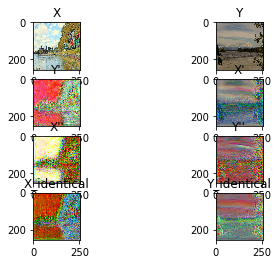

Epoch:  0 Batch:  50 Loss of Discriminator:  [0.4143371 0.25     ] Loss of Generator G:  [5.115462, 0.018505739, 0.28246018, 0.3600413, 0.20192471, 0.2657118, 0.15798983, 0.38012934, 0.19734986]


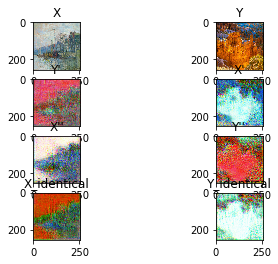

Epoch:  0 Batch:  60 Loss of Discriminator:  [0.40948397 0.5       ] Loss of Generator G:  [4.673875, 0.088686615, 0.08720836, 0.30029604, 0.37654325, 0.120098025, 0.27520263, 0.17550299, 0.36947072]


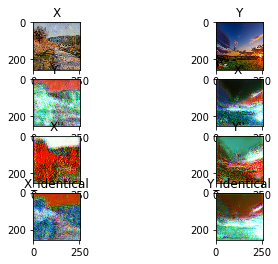

Epoch:  0 Batch:  70 Loss of Discriminator:  [0.1452129 0.5      ] Loss of Generator G:  [5.136058, 0.3219771, 0.08568291, 0.3240373, 0.4407043, 0.14698416, 0.25808817, 0.29749689, 0.3801778]


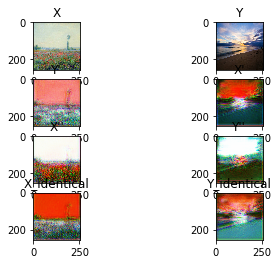

Epoch:  0 Batch:  80 Loss of Discriminator:  [0.05117792 0.5       ] Loss of Generator G:  [6.0305624, 0.48551014, 1.181225, 0.27537292, 0.43506426, 0.16781092, 0.2083373, 0.21231455, 0.39003035]


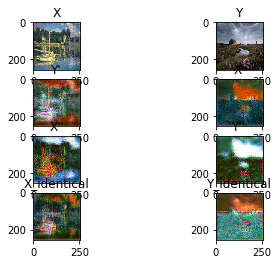

Epoch:  0 Batch:  90 Loss of Discriminator:  [0.11929286 0.5       ] Loss of Generator G:  [4.6272187, 0.68732166, 0.37794602, 0.28081885, 0.35680914, 0.13377236, 0.16994438, 0.21134214, 0.31344128]


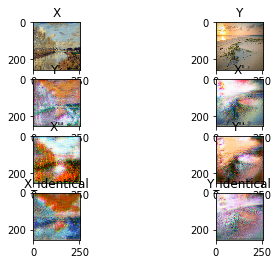

Epoch:  0 Batch:  100 Loss of Discriminator:  [0.49928766 0.        ] Loss of Generator G:  [2.1664875, 0.05111753, 0.03011158, 0.20392156, 0.23162341, 0.07355738, 0.10090156, 0.18957278, 0.15109624]


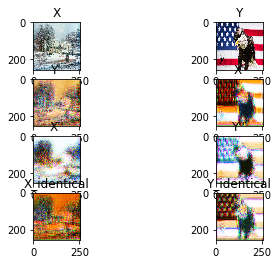

Epoch:  0 Batch:  110 Loss of Discriminator:  [0.5806515 0.25     ] Loss of Generator G:  [8.368548, 0.002820647, 1.5806904, 0.35172385, 0.68352497, 0.20892796, 0.39148486, 0.23868403, 0.5422258]


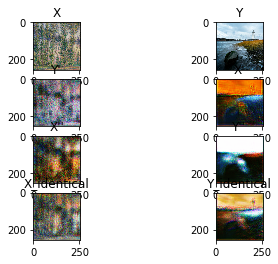

Epoch:  0 Batch:  120 Loss of Discriminator:  [0.23368748 0.5       ] Loss of Generator G:  [4.4247947, 0.20342213, 0.3174192, 0.2277178, 0.6296915, 0.12560561, 0.21578413, 0.13634764, 0.35370806]


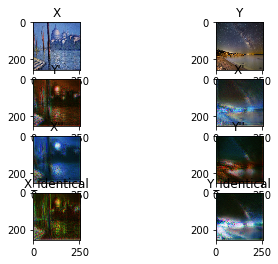

Epoch:  0 Batch:  130 Loss of Discriminator:  [0.4367598 0.25     ] Loss of Generator G:  [3.8511443, 0.3224622, 0.0245348, 0.29385227, 0.2437587, 0.15091935, 0.15927342, 0.21416262, 0.18805723]


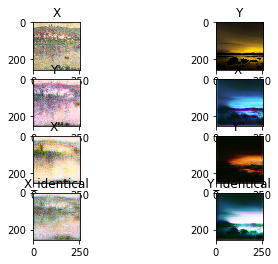

Epoch:  0 Batch:  140 Loss of Discriminator:  [0.38729504 0.5       ] Loss of Generator G:  [6.076947, 0.20976079, 0.28079522, 0.3033023, 0.57900083, 0.1173757, 0.39272642, 0.12796819, 0.35740113]


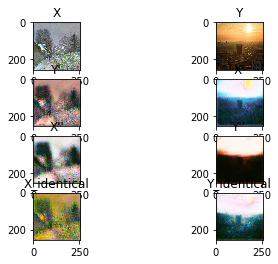

Epoch:  0 Batch:  150 Loss of Discriminator:  [0.1957547 0.5      ] Loss of Generator G:  [3.3703866, 0.061004896, 0.59107786, 0.22586536, 0.53247607, 0.088423274, 0.15520655, 0.1028039, 0.17920189]


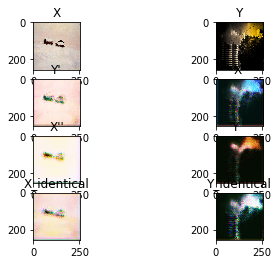

Epoch:  0 Batch:  160 Loss of Discriminator:  [0.21720812 0.25      ] Loss of Generator G:  [8.984037, 0.1716206, 0.20741643, 0.4608556, 0.59318686, 0.36970955, 0.41517502, 0.33368373, 0.4224707]


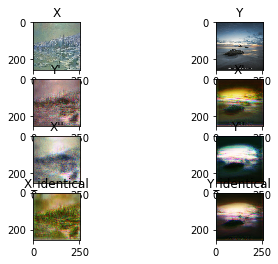

Epoch:  0 Batch:  170 Loss of Discriminator:  [0.45200083 0.5       ] Loss of Generator G:  [2.7007368, 0.11929431, 0.841715, 0.17148393, 0.29482502, 0.093270496, 0.061637685, 0.096328035, 0.09431764]


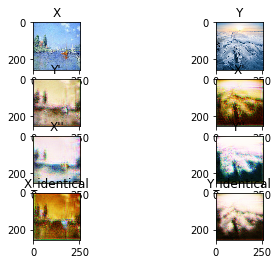

Epoch:  0 Batch:  180 Loss of Discriminator:  [0.33663946 0.25      ] Loss of Generator G:  [6.0741525, 0.2056147, 0.034614556, 0.32919973, 0.35169876, 0.26528823, 0.25875306, 0.3331673, 0.26034316]


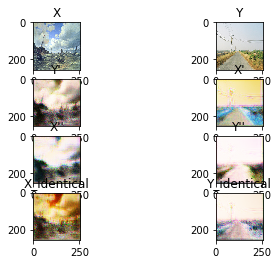

Epoch:  0 Batch:  190 Loss of Discriminator:  [0.03038655 0.5       ] Loss of Generator G:  [6.3808146, 0.30440578, 0.13521196, 0.21781674, 0.5420681, 0.12550168, 0.40833706, 0.15843399, 0.44437543]


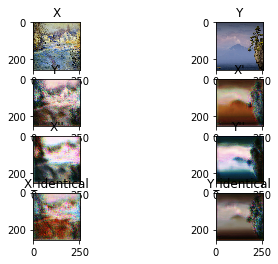

Epoch:  0 Batch:  200 Loss of Discriminator:  [0.18171632 0.25      ] Loss of Generator G:  [1.8931426, 0.0003896176, 0.15713677, 0.2672446, 0.25781754, 0.08691338, 0.06456709, 0.12804928, 0.09276219]


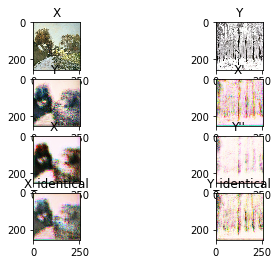

Epoch:  0 Batch:  210 Loss of Discriminator:  [0.16912735 0.5       ] Loss of Generator G:  [8.511938, 0.18473832, 0.17756468, 0.3616726, 0.78258574, 0.12177895, 0.61866343, 0.12765947, 0.61755204]


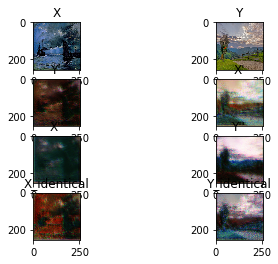

Epoch:  0 Batch:  220 Loss of Discriminator:  [0.47862327 0.        ] Loss of Generator G:  [3.4793282, 0.13631858, 0.07478463, 0.39692408, 0.2517298, 0.23296428, 0.059679948, 0.25299972, 0.08878285]


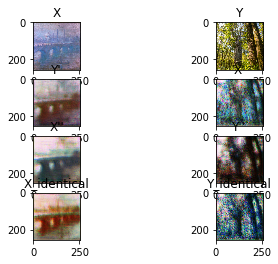

Epoch:  0 Batch:  230 Loss of Discriminator:  [0.27554724 0.25      ] Loss of Generator G:  [3.271821, 0.05003339, 0.07438975, 0.15291393, 0.3419675, 0.07202855, 0.21211675, 0.092027724, 0.21391737]


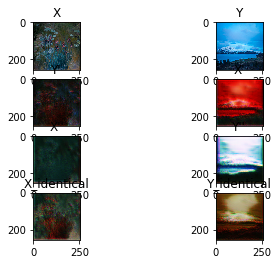

Epoch:  0 Batch:  240 Loss of Discriminator:  [0.39127403 0.25      ] Loss of Generator G:  [7.246974, 0.0023520535, 0.021127447, 0.43607467, 0.5928585, 0.3458439, 0.30181873, 0.3598426, 0.38702518]


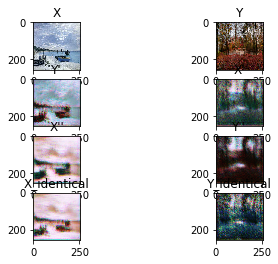

Epoch:  0 Batch:  250 Loss of Discriminator:  [0.21056399 0.25      ] Loss of Generator G:  [5.139959, 0.5233653, 0.24609372, 0.3526001, 0.35170335, 0.19602141, 0.20025131, 0.20379925, 0.20397332]


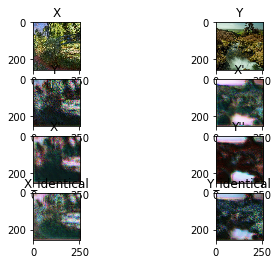

Epoch:  0 Batch:  260 Loss of Discriminator:  [0.22231895 0.5       ] Loss of Generator G:  [4.4824557, 0.11826096, 0.57984114, 0.39177167, 0.41362512, 0.22950408, 0.11296564, 0.23112158, 0.12853482]


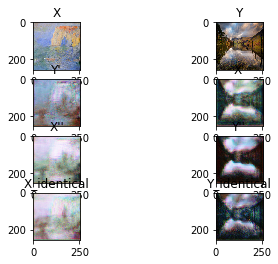

Epoch:  0 Batch:  270 Loss of Discriminator:  [0.16910467 0.25      ] Loss of Generator G:  [2.3223088, 0.14611694, 0.014395209, 0.19813709, 0.30492002, 0.11403354, 0.08072126, 0.12260907, 0.091639474]


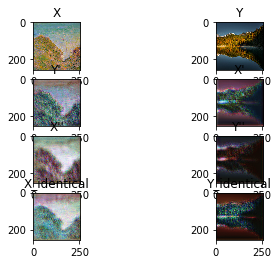

Epoch:  0 Batch:  280 Loss of Discriminator:  [0.33526573 0.25      ] Loss of Generator G:  [3.7052708, 0.117627, 0.003808102, 0.19704458, 0.43834132, 0.07897182, 0.24292865, 0.10025545, 0.26457545]


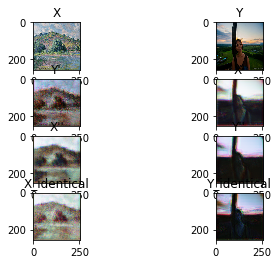

Epoch:  0 Batch:  290 Loss of Discriminator:  [0.23243392 0.5       ] Loss of Generator G:  [2.8990633, 0.4229395, 0.5391212, 0.15810731, 0.34644222, 0.062396444, 0.11305905, 0.06442232, 0.11802536]


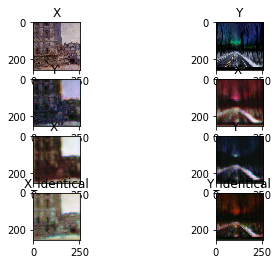

Epoch:  0 Batch:  300 Loss of Discriminator:  [0.02256095 0.5       ] Loss of Generator G:  [5.3222704, 0.15650669, 1.3105246, 0.3019102, 0.52852905, 0.07014422, 0.2796349, 0.07466222, 0.28278518]


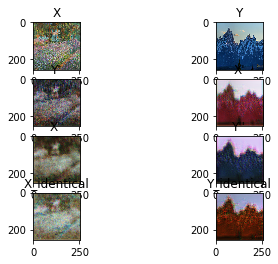

Epoch:  0 Batch:  310 Loss of Discriminator:  [0.1151512 0.5      ] Loss of Generator G:  [3.0520988, 0.14783514, 0.5287923, 0.26263833, 0.5142315, 0.10268287, 0.111306384, 0.1105567, 0.12502205]


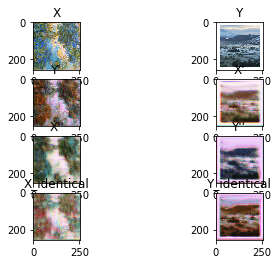

Epoch:  0 Batch:  320 Loss of Discriminator:  [0.1375407 0.5      ] Loss of Generator G:  [5.7196994, 0.52027947, 1.1543946, 0.26515615, 0.726032, 0.07593398, 0.28758872, 0.09491361, 0.31488448]


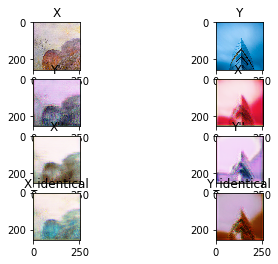

Epoch:  0 Batch:  330 Loss of Discriminator:  [0.15847851 0.25      ] Loss of Generator G:  [5.153679, 0.11840842, 0.06199323, 0.17651546, 0.42398143, 0.121310115, 0.32800972, 0.12733786, 0.35274062]


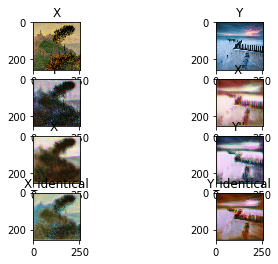

Epoch:  0 Batch:  340 Loss of Discriminator:  [0.18954846 0.25      ] Loss of Generator G:  [3.1383848, 0.06674128, 0.079680465, 0.4237692, 0.4857002, 0.13336894, 0.13783316, 0.14037031, 0.13957171]


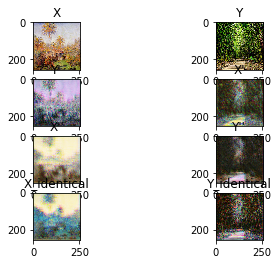

Epoch:  0 Batch:  350 Loss of Discriminator:  [0.09905189 0.25      ] Loss of Generator G:  [4.287728, 0.14606996, 0.025077004, 0.3710776, 0.57040226, 0.10794583, 0.26567343, 0.11667636, 0.26371172]


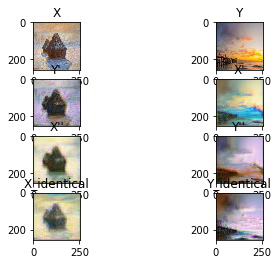

Epoch:  0 Batch:  360 Loss of Discriminator:  [0.12931658 0.5       ] Loss of Generator G:  [3.3254251, 0.69894576, 0.00401355, 0.26642513, 0.4245292, 0.077177495, 0.15499756, 0.10384202, 0.19687314]


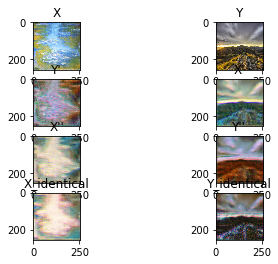

Epoch:  0 Batch:  370 Loss of Discriminator:  [0.03394339 0.5       ] Loss of Generator G:  [3.2450442, 0.7985373, 0.3763312, 0.29913768, 0.34180945, 0.12887028, 0.053910412, 0.16427979, 0.07808907]


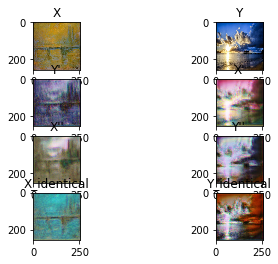

Epoch:  0 Batch:  380 Loss of Discriminator:  [0.38683122 0.25      ] Loss of Generator G:  [3.2156374, 0.20344318, 0.19051486, 0.19270012, 0.31776106, 0.15574646, 0.096006185, 0.15110168, 0.15305135]


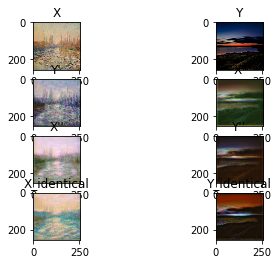

Epoch:  0 Batch:  390 Loss of Discriminator:  [0.12237111 0.5       ] Loss of Generator G:  [4.726285, 0.093712434, 0.14526357, 0.16663301, 0.4845876, 0.07042937, 0.33512425, 0.072262354, 0.35951024]


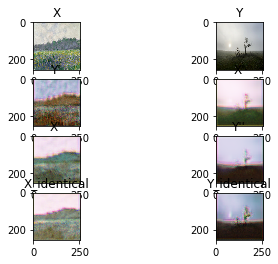

Epoch:  0 Batch:  400 Loss of Discriminator:  [0.27423355 0.25      ] Loss of Generator G:  [3.050959, 0.11958468, 0.08355865, 0.13494985, 0.30869317, 0.0836266, 0.17545043, 0.087933436, 0.169112]


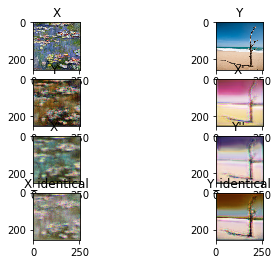

Epoch:  0 Batch:  410 Loss of Discriminator:  [0.424901 0.      ] Loss of Generator G:  [4.125294, 0.2365504, 0.015664259, 0.21191438, 0.51147556, 0.1015933, 0.24556541, 0.10073455, 0.30075777]


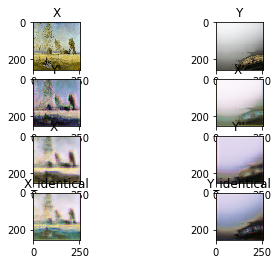

Epoch:  0 Batch:  420 Loss of Discriminator:  [0.20221493 0.5       ] Loss of Generator G:  [5.68536, 0.8076601, 0.77362263, 0.15742879, 0.4615844, 0.0827214, 0.29075325, 0.08900282, 0.2803278]


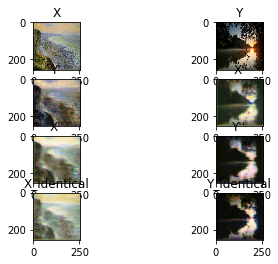

Epoch:  0 Batch:  430 Loss of Discriminator:  [0.08278498 0.25      ] Loss of Generator G:  [3.1629515, 0.010067866, 0.7564398, 0.2072643, 0.49430278, 0.040161256, 0.17729801, 0.04181448, 0.18003657]


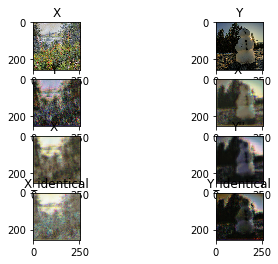

Epoch:  0 Batch:  440 Loss of Discriminator:  [0.25148714 0.25      ] Loss of Generator G:  [2.6755066, 0.28187075, 0.059324358, 0.25718, 0.35348386, 0.100099295, 0.11142627, 0.097644776, 0.121410966]


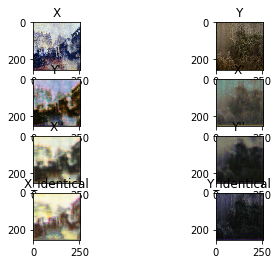

Epoch:  0 Batch:  450 Loss of Discriminator:  [0.08229019 0.5       ] Loss of Generator G:  [3.0965426, 0.3229206, 0.32517233, 0.19727549, 0.19773732, 0.09899766, 0.12252101, 0.10598768, 0.12727506]


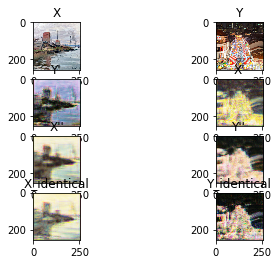

Epoch:  0 Batch:  460 Loss of Discriminator:  [0.19275051 0.5       ] Loss of Generator G:  [3.9926662, 0.21586102, 0.386249, 0.52923185, 0.7296327, 0.14260317, 0.16427822, 0.14438267, 0.17735946]


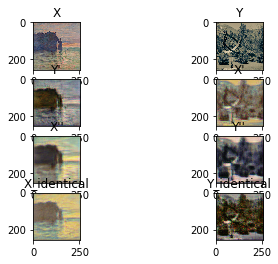

Epoch:  0 Batch:  470 Loss of Discriminator:  [0.2618634 0.5      ] Loss of Generator G:  [2.8329997, 0.9800776, 0.61095697, 0.12862606, 0.2609427, 0.03608735, 0.076575354, 0.03827389, 0.077064335]


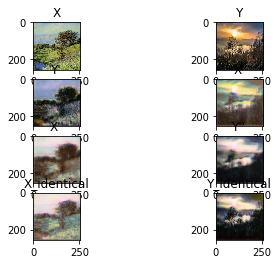

Epoch:  0 Batch:  480 Loss of Discriminator:  [0.13752331 0.25      ] Loss of Generator G:  [2.0500922, 0.5035591, 0.042535797, 0.21027511, 0.333943, 0.06369448, 0.07176208, 0.07057424, 0.07885746]


KeyboardInterrupt: 

In [6]:
cycleGAN = CycleGAN()
cycleGAN.train()
#cycleGAN.generators.summary()
with tf.device('/device:GPU:1'):
    cycleGAN.generators.save('./models/conv2_adam_30epoch_group.h5')